In [1]:
import os 
os.environ["LOCKY_MAX_CPU_COUNT"] = "4"

Computing embedding


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Done.
ward :	0.60s
average :	0.10s
complete :	0.09s
single :	0.06s


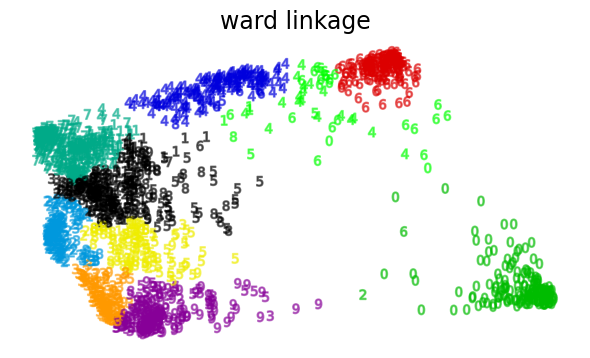

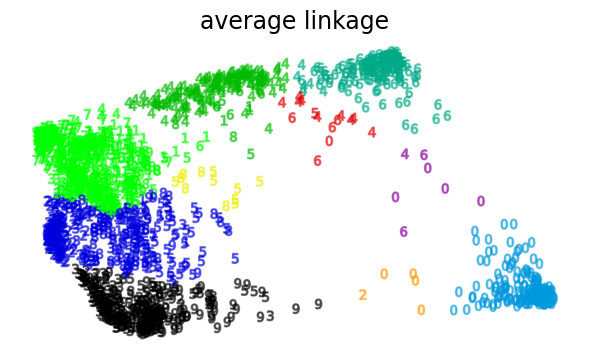

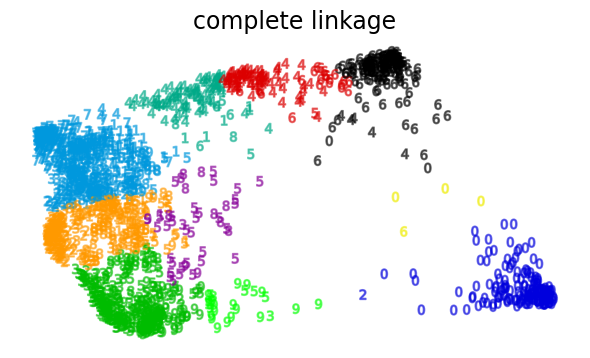

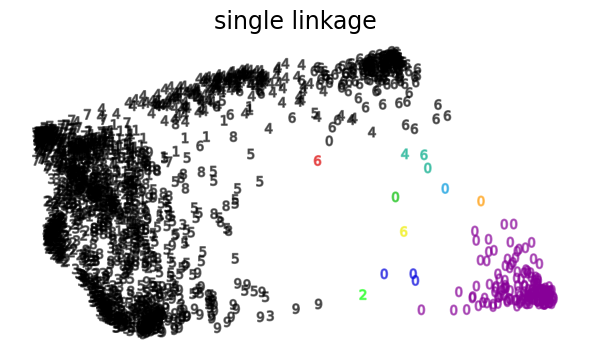

In [2]:
# Authors: Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2014

from time import time

import numpy as np
from matplotlib import pyplot as plt

from sklearn import datasets, manifold

digits = datasets.load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

np.random.seed(0)


# ----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for digit in digits.target_names:
        plt.scatter(
            *X_red[y == digit].T,
            marker=f"${digit}$",
            s=50,
            c=plt.cm.nipy_spectral(labels[y == digit] / 10),
            alpha=0.5,
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# ----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

In [3]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler

In [4]:
n_samples = 1500
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=170
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=170)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=170)
rng = np.random.RandomState(170)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
X, y = datasets.make_blobs(n_samples=n_samples, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=170
)

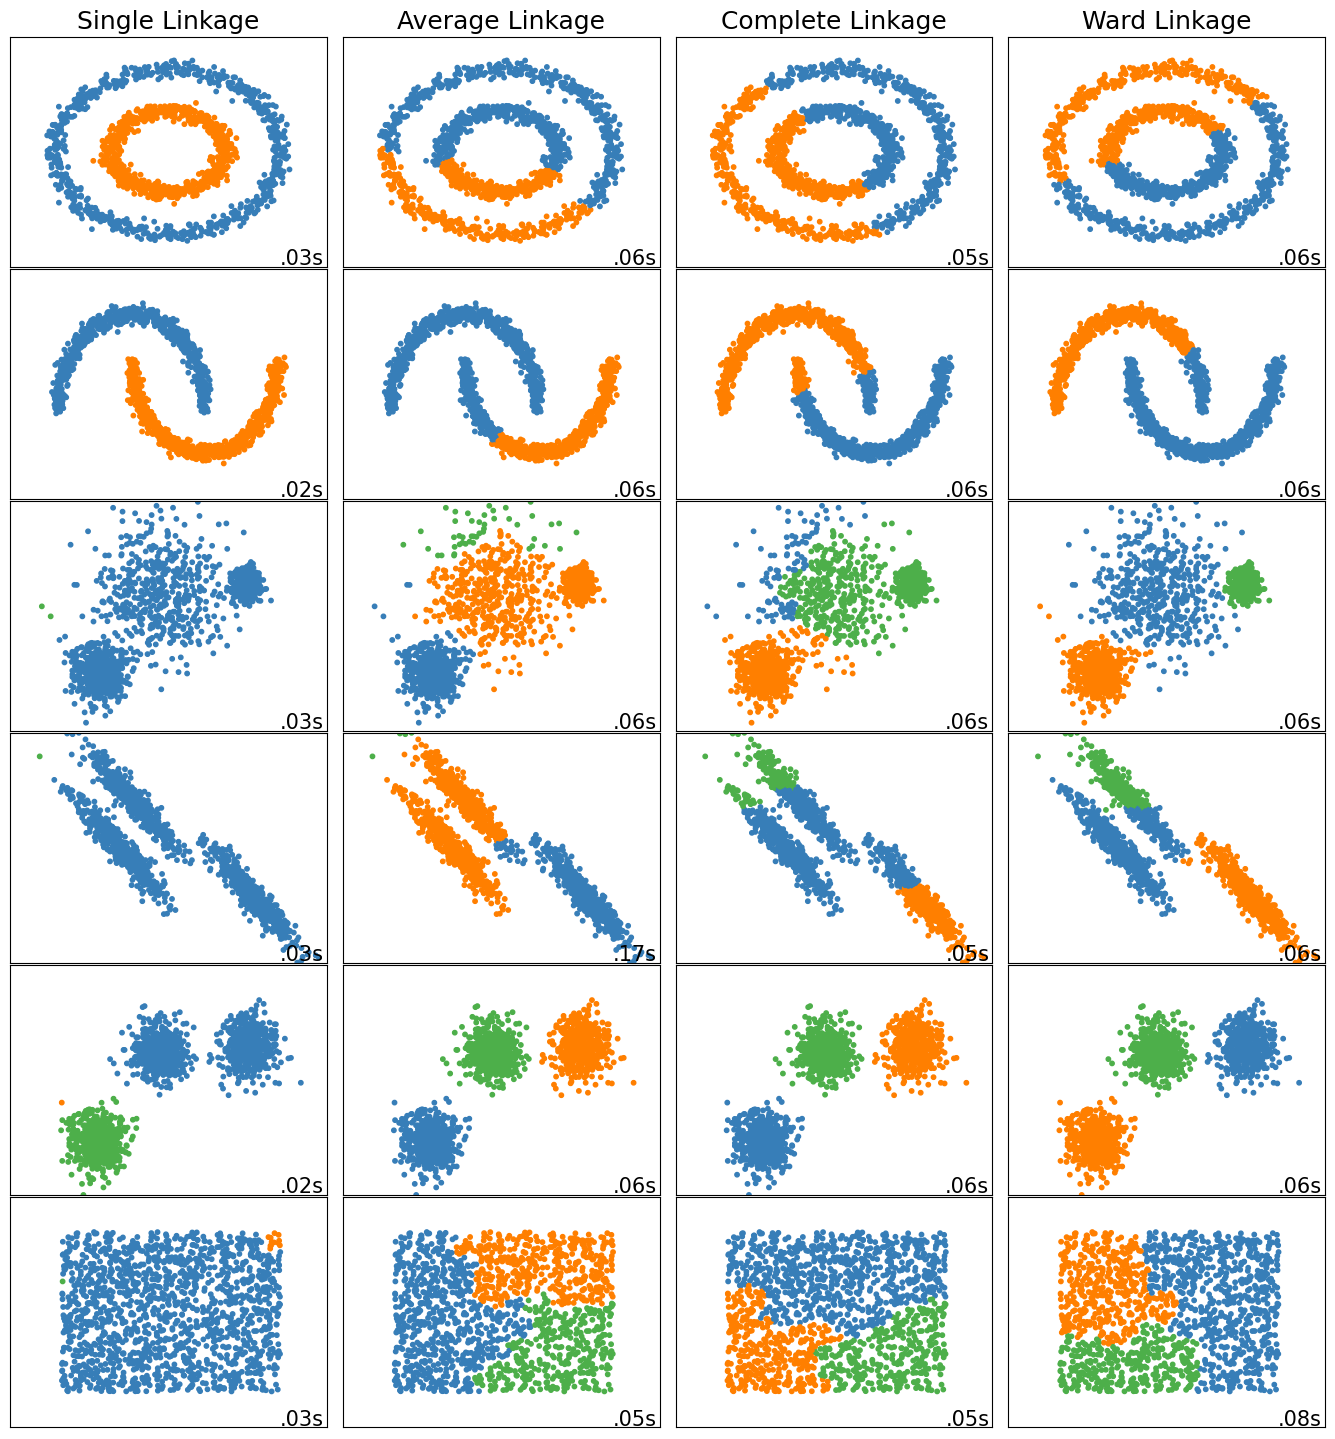

In [5]:
# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {"n_neighbors": 10, "n_clusters": 3}

datasets = [
    (noisy_circles, {"n_clusters": 2}),
    (noisy_moons, {"n_clusters": 2}),
    (varied, {"n_neighbors": 2}),
    (aniso, {"n_neighbors": 2}),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward"
    )
    complete = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="complete"
    )
    average = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="average"
    )
    single = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="single"
    )

    clustering_algorithms = (
        ("Single Linkage", single),
        ("Average Linkage", average),
        ("Complete Linkage", complete),
        ("Ward Linkage", ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

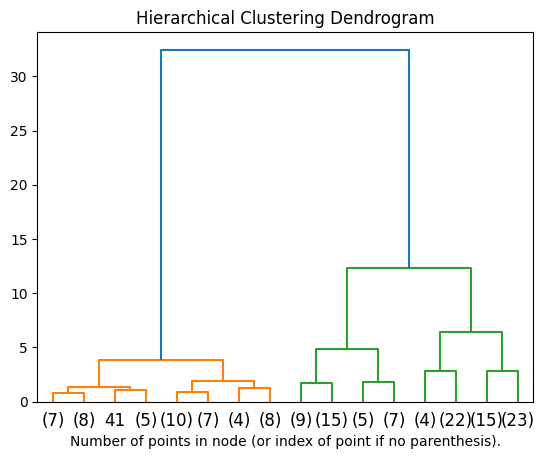

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [20]:
np.unique(iris['target'])

array([0, 1, 2])

In [21]:
model.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int64)

In [7]:
# Authors : Vincent Michel, 2010
#           Alexandre Gramfort, 2010
#           Gael Varoquaux, 2010
# License: BSD 3 clause

import time as time

# The following import is required
# for 3D projection to work with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

In [8]:
from sklearn.cluster import AgglomerativeClustering

print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage="ward").fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print(f"Elapsed time: {elapsed_time:.2f}s")
print(f"Number of points: {label.size}")

Compute unstructured hierarchical clustering...
Elapsed time: 0.00s
Number of points: 150


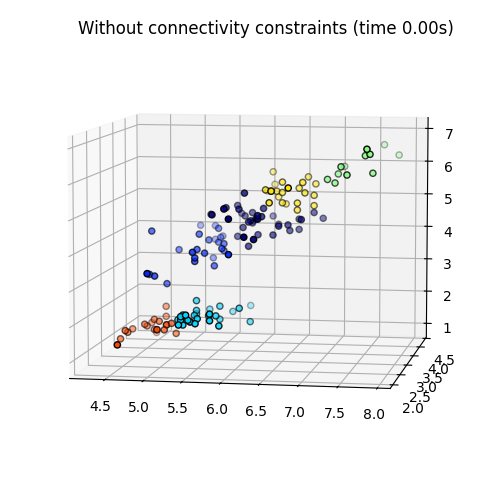

In [9]:
import matplotlib.pyplot as plt

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection="3d", elev=7, azim=-80)
ax1.set_position([0, 0, 0.95, 1])
for l in np.unique(label):
    ax1.scatter(
        X[label == l, 0],
        X[label == l, 1],
        X[label == l, 2],
        color=plt.cm.jet(float(l) / np.max(label + 1)),
        s=20,
        edgecolor="k",
    )
_ = fig1.suptitle(f"Without connectivity constraints (time {elapsed_time:.2f}s)")

In [10]:
from sklearn.neighbors import kneighbors_graph

connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

In [11]:
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(
    n_clusters=6, connectivity=connectivity, linkage="ward"
).fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print(f"Elapsed time: {elapsed_time:.2f}s")
print(f"Number of points: {label.size}")

Compute structured hierarchical clustering...


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_agglomerative.py:322: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


Elapsed time: 0.91s
Number of points: 150


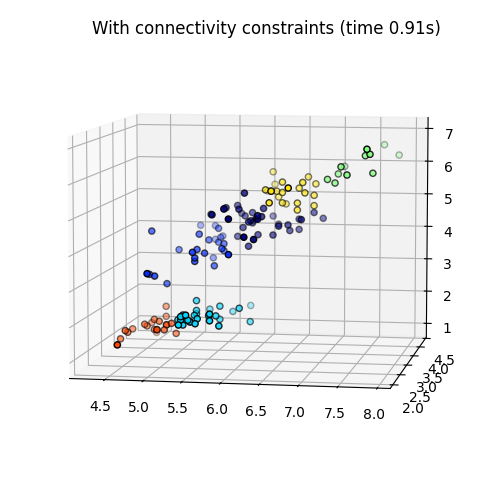

In [12]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(121, projection="3d", elev=7, azim=-80)
ax2.set_position([0, 0, 0.95, 1])
for l in np.unique(label):
    ax2.scatter(
        X[label == l, 0],
        X[label == l, 1],
        X[label == l, 2],
        color=plt.cm.jet(float(l) / np.max(label + 1)),
        s=20,
        edgecolor="k",
    )
fig2.suptitle(f"With connectivity constraints (time {elapsed_time:.2f}s)")

plt.show()

In [22]:
AGC = AgglomerativeClustering(linkage='average',metric='euclidean',n_clusters=3)

In [23]:
from sklearn.datasets import make_blobs

In [24]:
data,_ = make_blobs(n_samples=200,n_features=5)

In [25]:
AGC.fit(data)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [31]:
AGC.fit_predict(data)

array([2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 0, 0, 0, 0, 2, 1, 2, 1, 2, 0,
       0, 1, 1, 2, 2, 1, 1, 2, 2, 1, 0, 1, 0, 1, 1, 0, 0, 2, 2, 2, 2, 0,
       0, 1, 0, 1, 2, 1, 2, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 2, 0, 2, 0, 0,
       1, 2, 2, 1, 1, 1, 1, 0, 2, 0, 1, 2, 1, 1, 2, 0, 0, 2, 0, 1, 2, 2,
       1, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0, 2,
       2, 1, 1, 0, 2, 1, 1, 2, 0, 0, 0, 1, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2,
       1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 2, 2, 0, 2, 1, 1, 0, 2, 0,
       1, 1, 2, 0, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0, 0, 1, 2, 2, 2, 0, 1, 2,
       1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 1, 2,
       2, 1], dtype=int64)

In [26]:
AGC.labels_

array([2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 0, 0, 0, 0, 2, 1, 2, 1, 2, 0,
       0, 1, 1, 2, 2, 1, 1, 2, 2, 1, 0, 1, 0, 1, 1, 0, 0, 2, 2, 2, 2, 0,
       0, 1, 0, 1, 2, 1, 2, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 2, 0, 2, 0, 0,
       1, 2, 2, 1, 1, 1, 1, 0, 2, 0, 1, 2, 1, 1, 2, 0, 0, 2, 0, 1, 2, 2,
       1, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0, 2,
       2, 1, 1, 0, 2, 1, 1, 2, 0, 0, 0, 1, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2,
       1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 2, 2, 0, 2, 1, 1, 0, 2, 0,
       1, 1, 2, 0, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0, 0, 1, 2, 2, 2, 0, 1, 2,
       1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 1, 2,
       2, 1], dtype=int64)

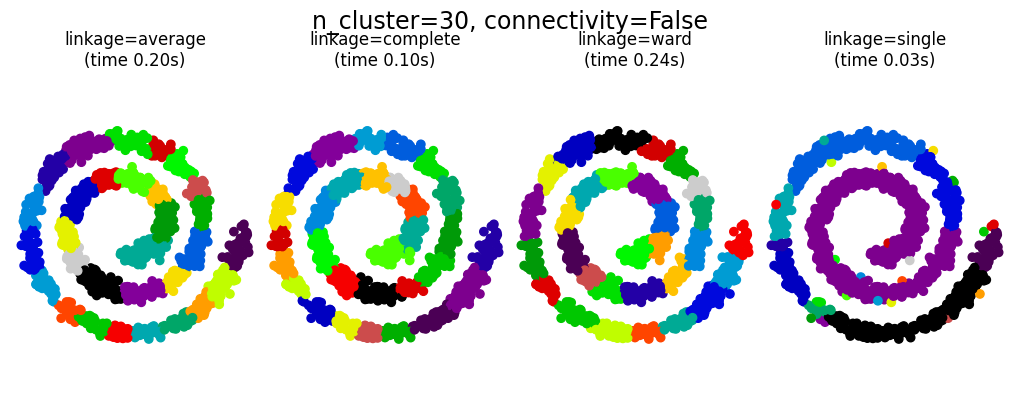

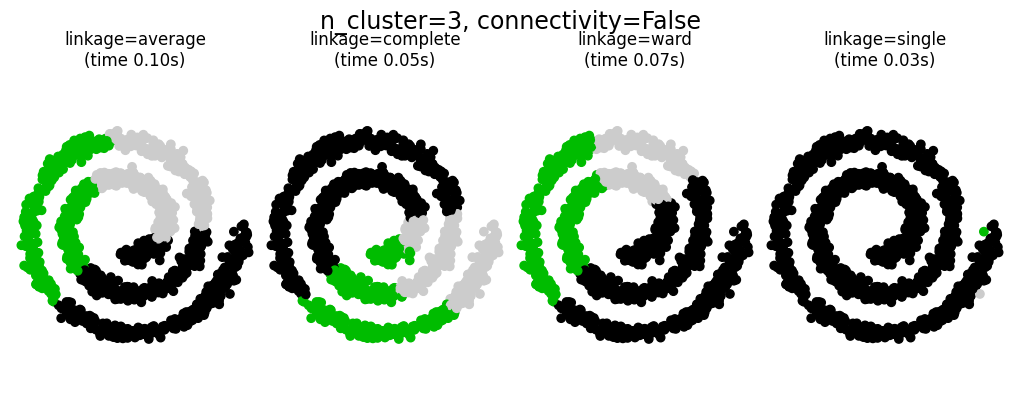

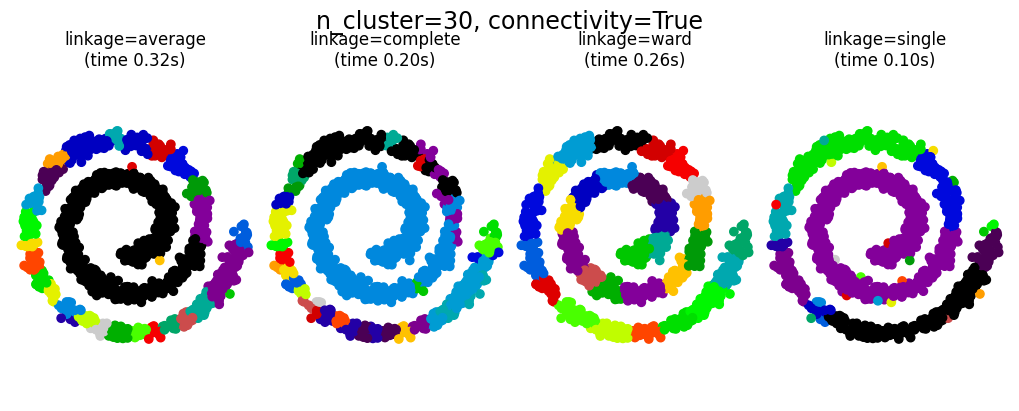

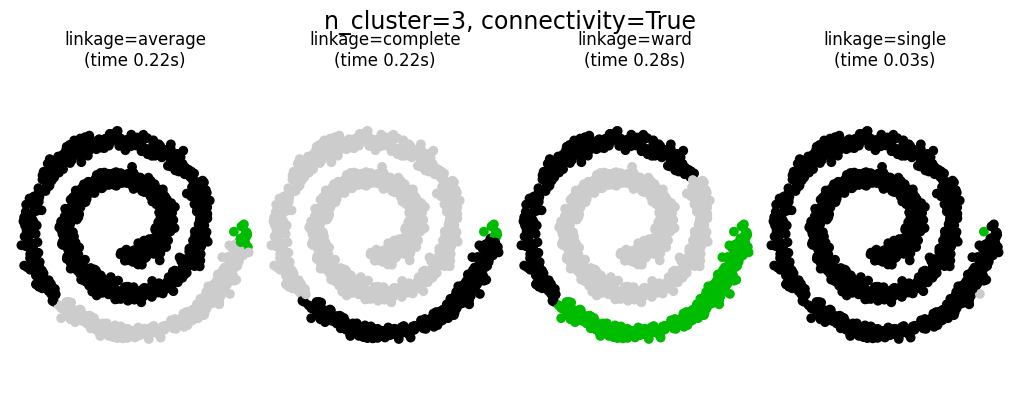

In [18]:
# Authors: Gael Varoquaux, Nelle Varoquaux
# License: BSD 3 clause

import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += 0.7 * np.random.randn(2, n_samples)
X = X.T

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(("average", "complete", "ward", "single")):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(
                linkage=linkage, connectivity=connectivity, n_clusters=n_clusters
            )
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral)
            plt.title(
                "linkage=%s\n(time %.2fs)" % (linkage, elapsed_time),
                fontdict=dict(verticalalignment="top"),
            )
            plt.axis("equal")
            plt.axis("off")

            plt.subplots_adjust(bottom=0, top=0.83, wspace=0, left=0, right=1)
            plt.suptitle(
                "n_cluster=%i, connectivity=%r"
                % (n_clusters, connectivity is not None),
                size=17,
            )


plt.show()

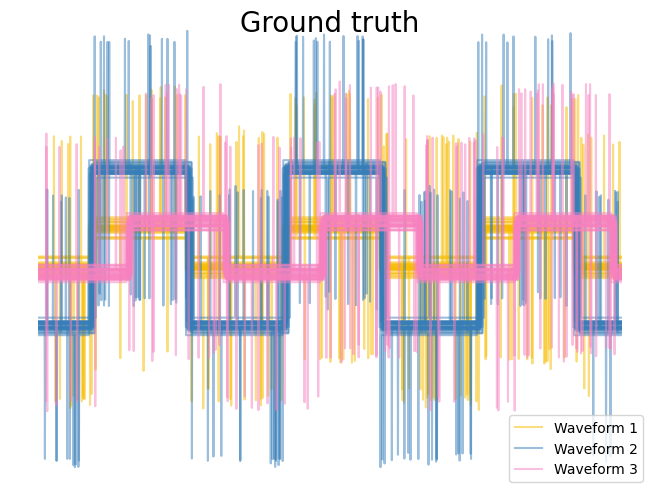

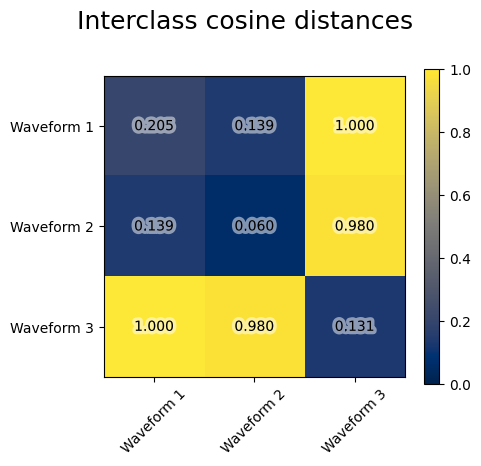

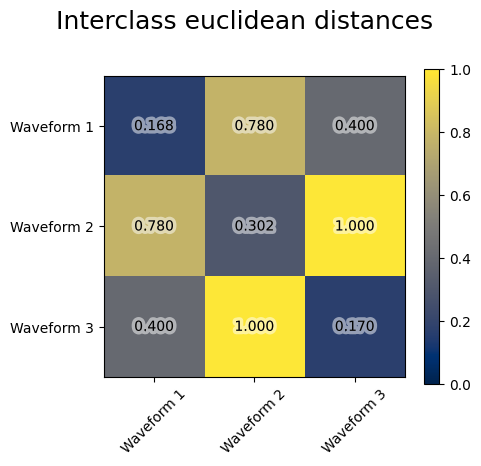

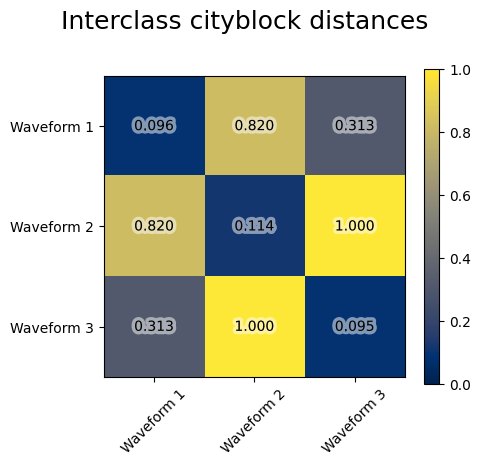

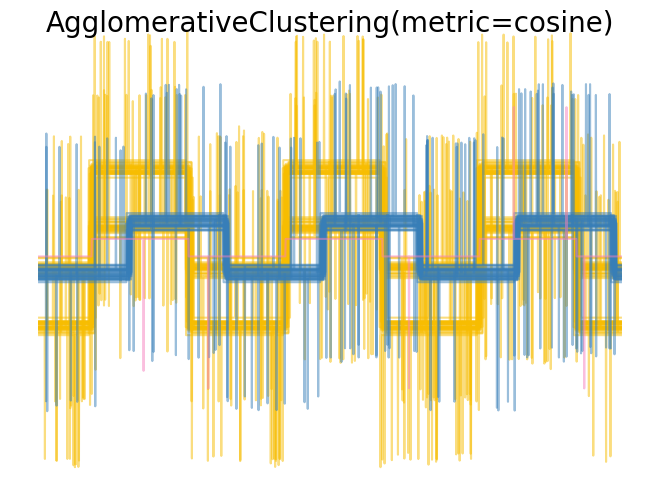

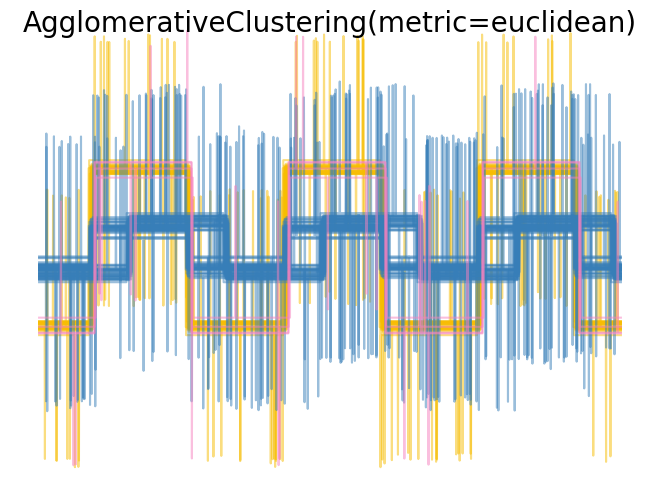

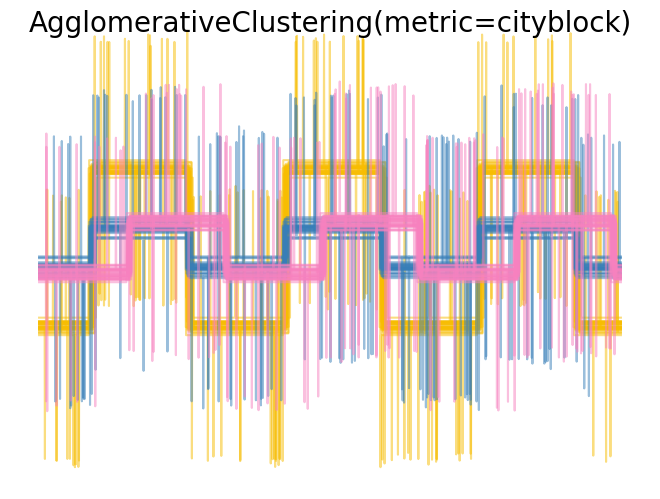

In [19]:
# Author: Gael Varoquaux
# License: BSD 3-Clause or CC-0

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

np.random.seed(0)

# Generate waveform data
n_features = 2000
t = np.pi * np.linspace(0, 1, n_features)


def sqr(x):
    return np.sign(np.cos(x))


X = list()
y = list()
for i, (phi, a) in enumerate([(0.5, 0.15), (0.5, 0.6), (0.3, 0.2)]):
    for _ in range(30):
        phase_noise = 0.01 * np.random.normal()
        amplitude_noise = 0.04 * np.random.normal()
        additional_noise = 1 - 2 * np.random.rand(n_features)
        # Make the noise sparse
        additional_noise[np.abs(additional_noise) < 0.997] = 0

        X.append(
            12
            * (
                (a + amplitude_noise) * (sqr(6 * (t + phi + phase_noise)))
                + additional_noise
            )
        )
        y.append(i)

X = np.array(X)
y = np.array(y)

n_clusters = 3

labels = ("Waveform 1", "Waveform 2", "Waveform 3")

colors = ["#f7bd01", "#377eb8", "#f781bf"]

# Plot the ground-truth labelling
plt.figure()
plt.axes([0, 0, 1, 1])
for l, color, n in zip(range(n_clusters), colors, labels):
    lines = plt.plot(X[y == l].T, c=color, alpha=0.5)
    lines[0].set_label(n)

plt.legend(loc="best")

plt.axis("tight")
plt.axis("off")
plt.suptitle("Ground truth", size=20, y=1)


# Plot the distances
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    avg_dist = np.zeros((n_clusters, n_clusters))
    plt.figure(figsize=(5, 4.5))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(
                X[y == i], X[y == j], metric=metric
            ).mean()
    avg_dist /= avg_dist.max()
    for i in range(n_clusters):
        for j in range(n_clusters):
            t = plt.text(
                i,
                j,
                "%5.3f" % avg_dist[i, j],
                verticalalignment="center",
                horizontalalignment="center",
            )
            t.set_path_effects(
                [PathEffects.withStroke(linewidth=5, foreground="w", alpha=0.5)]
            )

    plt.imshow(avg_dist, interpolation="nearest", cmap="cividis", vmin=0)
    plt.xticks(range(n_clusters), labels, rotation=45)
    plt.yticks(range(n_clusters), labels)
    plt.colorbar()
    plt.suptitle("Interclass %s distances" % metric, size=18, y=1)
    plt.tight_layout()


# Plot clustering results
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    model = AgglomerativeClustering(
        n_clusters=n_clusters, linkage="average", metric=metric
    )
    model.fit(X)
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, color in zip(np.arange(model.n_clusters), colors):
        plt.plot(X[model.labels_ == l].T, c=color, alpha=0.5)
    plt.axis("tight")
    plt.axis("off")
    plt.suptitle("AgglomerativeClustering(metric=%s)" % metric, size=20, y=1)


plt.show()